In [62]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации
%matplotlib inline
plt.style.use('seaborn') # установка стиля matplotlib

from sklearn import linear_model # Для работы SGDRegressor
from sklearn import metrics

Будем работать с датасетом из библиотеки sklearn о домах в Бостоне. Этот набор данных содержит информацию, собранную службой переписи населения США и касающуюся жилья в районе Бостона, штат Массачусетс.

Данный датасет содержится в модуле datasets библиотеки sklearn. Давайте загрузим датасет с помощью функции load_boston() и выведем его описание, обратившись по ключу 'DESCR':

* CRIM — уровень преступности на душу населения по городам.;
* ZN — доля земли под жилую застройку, разделённая на участки площадью более 25 000 кв. футов;
* INDUS — доля акров, которые принадлежат предприятиям, не связанным с розничной торговлей, на город;
* CHAS —фиктивная переменная реки Чарльз (1 — если участок прилегает к реке; 0 — в противном случае);
* NOX —концентрация оксидов азота (в десятимиллионных долях);
* RM —среднее количество комнат в доме;
* AGE —доля зданий, построенных до 1940 г. и занимаемых владельцами;
* DIS — взвешенные расстояния до пяти бостонских центров занятости;
* RAD — индекс доступности радиальных автомобильных дорог;
* TAX — полная ставка налога на имущество за каждые 10 000 долларов стоимости;
* PTRATIO — соотношение учеников и учителей по городам;
* B — 1000 (Bk — 0.63) , где Bk — доля граждан афроамериканского происхождения по городам;
* LSTAT — процент населения с низким статусом;
* MEDV — медианное значение стоимости домов, занимаемых владельцами, в тысячах долларов США (целевой признак).

In [63]:
from sklearn.datasets import load_boston 
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Задача — научить модель предсказывать медианную стоимость дома на участке.

Составим DataFrame из наших данных. Для этого обратимся по ключу 'data' к загруженным данным и получим numpy-массив, в котором содержится информация обо всех признаках, а по ключу 'feature_names' содержатся названия признаков. Обратившись по ключу 'target', можно получить numpy-вектор со значениями целевой переменной — медианной стоимости занимаемых домов (MEDV).

In [64]:
# создаём DataFrame из загруженных numpy-матриц
boston_data = pd.DataFrame(
    data=boston.data, # данные
    columns=boston.feature_names # наименования столбцов
)
# добавляем в таблицу столбец с целевой переменной
boston_data['MEDV'] = boston.target
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [65]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


**Примечание.** Модель линейной регрессии требует, чтобы в подаваемых ей на вход данных не было пропущенных значений. Поэтому если в ваших данных окажутся пропуски, обязательно заранее позаботьтесь о них (способы мы изучали в модуле по очистке данных).

Давайте начнём с простого. Построим линейную регрессию на одном признаке. Выберем признак, который имеет наиболее высокую линейную взаимосвязь. Для этого рассчитаем корреляцию признаков с целевой переменной и выберем наиболее влиятельный.

**Примечание.** Мы могли визуализировать матрицу корреляций, однако сейчас нас интересует только связь факторов с целевым признаком, поэтому нагляднее будет воспользоваться столбчатой диаграммой.

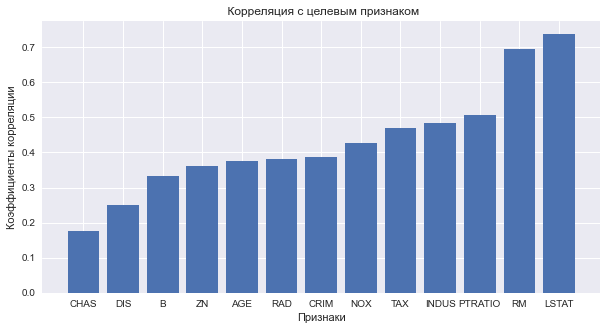

In [66]:
#Вычисляем модуль корреляции
corr_with_target = boston_data.corr()['MEDV'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('MEDV')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) # фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) # столбчатая диаграмма
ax.set_title(' Корреляция с целевым признаком') # название графика
ax.set_xlabel('Признаки') #название оси x
ax.set_ylabel('Коэффициенты корреляции'); #название оси y

Итак, самый коррелированный по модулю с медианной ценой (MEDV) признак — процент населения с низким статусом (LSTAT). Построим линейную регрессию, используя этот признак.

**Примечание.** Построить линейную регрессию = обучить линейную регрессию = найти её параметры.

In [67]:
X = boston_data[['LSTAT']] # матрица наблюдений
y = boston_data['MEDV'] # вектор правильных ответов
X.head()
#y.head()

,LSTAT
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


**Примечание.** Двойные квадратные скобки boston_data[['LSTAT']] позволяют выбрать признак из DataFrame, сохранив его в виде таблицы. Это важно, так как в формуле МНК  — это матрица.

Будем использовать реализацию стохастического градиентного спуска для линейной регрессии из библиотеки sklearn — SGDRegressor. Она находится в том же модуле linear_model (from sklearn import linear_model).

У класса SGDRegressor есть множество параметров. Например, параметр random_state отвечает за число, на основе которого происходит генерация  случайных чисел. Напомним, в SGD случайность присутствует в инициализации параметров и выборе части из набора данных. Установив значение параметра random_state равным определённому числу, мы можем гарантировать одинаковые результаты работы метода при разных запусках. Пусть это будет число 42.

Для обучения используется метод fit(): он запускает работу градиентного спуска для поиска параметров, в него необходимо передать данные и правильные ответы.

In [68]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_lstat = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
sgd_lr_lstat.fit(X, y)

SGDRegressor(random_state=42)

Обучение завершено, параметры найдены. Давайте выведем их на экран. Для этого используются уже знакомые вам атрибуты coef_ и intercept_:

In [69]:
print('w0: {}'.format(sgd_lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(sgd_lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [34.33010969]
w1: [-0.96193242]


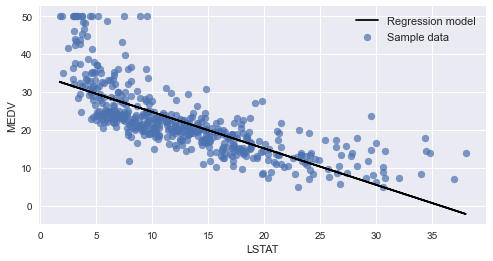

In [70]:
#функция для визуализации регрессии
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X.to_numpy(), y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда
#Предсказываем медианную цену для всех участков из набора данных
y_predict = sgd_lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

In [71]:
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: 0.542


Теперь попробуем обучить многомерную линейную регрессию с помощью SGD. Как и раньше составим полную матрицу наблюдений  из всех факторов, которые нам даны. Обучим модель и выведем значения коэффициентов в виде DataFrame:

In [72]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
 
#Создаём объект класса линейной регрессии с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
sgd_lr_full.fit(X, y)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': sgd_lr_full.coef_})
#Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,2.156857e+11
1,ZN,1.248446e+10
2,INDUS,7.277644e+09
3,CHAS,8.306154e+09
4,NOX,-8.413828e+09
5,RM,-3.148182e+10
6,AGE,8.685820e+10
7,DIS,-2.256141e+11
8,RAD,-4.683208e+10
9,TAX,1.892286e+09


In [73]:
#Предсказываем медианную цену для всех участков из набора данных
y_predict = sgd_lr_full.predict(X)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: -10590303862129977211224064.000


При использовании градиентного спуска и его модификаций очень важно масштабировать данные с помощью нормализации или стандартизации. Иначе алгоритм теряется в таком растянутом пространстве из-за неравномерных градиентов.

In [74]:
from sklearn import preprocessing
 
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Производим стандартизацию
X_scaled = scaler.fit_transform(X)
#Составляем DataFrame из результата
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


In [75]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_full.fit(X_scaled, y)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': sgd_lr_full.coef_})
#Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.870552
1,ZN,0.947112
2,INDUS,-0.116802
3,CHAS,0.730289
4,NOX,-1.894276
5,RM,2.757578
6,AGE,-0.027846
7,DIS,-3.049237
8,RAD,1.957066
9,TAX,-1.305271


In [76]:
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_full.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: 0.740


**Важно!** Если вы обучили модель на стандартизованных данных, то и для предсказания необходимо передавать их в стандартизованном виде.

Например, если попытаться сделать предсказание с помощью построенной модели, передав в качестве матрицы наблюдений нестандартизованную таблицу, то ошибки мы не получим, однако значение метрики будет неадекватным:

In [77]:
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_full.predict(X)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: -1856.503


У класса SGDRegressor, помимо random_state, есть ещё множество различных внешних параметров, которые можно настраивать. Со всем списком вы можете ознакомиться в документации. А мы приведём несколько самых важных:

* loss — функция потерь. По умолчанию используется squared_loss — уже привычная нам MSE. Но могут использоваться и несколько других. Например, значение "huber" определяет функцию потерь Хьюбера. Эта функция менее чувствительна к наличию выбросов, чем MSE.
* max_iter — максимальное количество итераций, выделенное на сходимость. Значение по умолчанию — 1000.
* learning_rate — режим управления темпом обучения. Значение по умолчанию — 'invscaling'. Этот режим уменьшает темп обучения по формуле, которую мы рассматривали ранее: .
Есть ещё несколько режимов управления, о которых вы можете прочитать в документации.

Если вы не хотите, чтобы темп обучения менялся на протяжении всего обучения, то можете выставить значение параметра на "constant".

* eta0 — начальное значение темпа обучения . Значение по умолчанию — 0.01.
Если параметр learning_rate="constant", то значение этого параметра будет темпом обучения на протяжении всех итераций.

* power_t — значение мощности уменьшения  в формуле  . Значение по умолчанию — 0.25.

Давайте посмотрим, что будет, если выставить константный режим управления темпом обучения и задать ему более высокое значение, например 0.1:

In [78]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad = linear_model.SGDRegressor(
    learning_rate='constant', #режим темпа обучения — константа
    eta0=0.1, #начальное и постоянное значение темпа обучения
    random_state=42
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: -335415038359.635


Вот ещё один плохой пример. Что будет, если поставить слишком маленькое значение параметра eta0? Например, 0.000001.

*→ Так как модель линейной регрессии является довольно простой и исследованной, то значения параметров, которые обладают наибольшей эффективностью, уже установлены по умолчанию (аргументы по умолчанию), но бывают ситуации, когда поэкспериментировать с параметрами может быть полезно, чтобы попытаться повысить качество.*

In [79]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad2 = linear_model.SGDRegressor(
    learning_rate='constant', #режим темпа обучения — константа
    eta0=1e-6, #начальное и постоянное значение темпа обучения
    random_state=42
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad2.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad2.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: -1.578


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### Задание 4.9

Найдите в документации параметр, отвечающий на критерий остановки (по умолчанию он равен 0.001).
Обучите SGDRegressor на датасете о домах в Бостоне с параметром остановки, равным 0.1, и random_state = 42. Остальные параметры оставьте по умолчанию.

Рассчитайте коэффициент детерминации . Ответ округлите до третьего знака после точки-разделителя. Сделайте вывод по полученным результатам.

In [80]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_bad2 = linear_model.SGDRegressor(
    #learning_rate='constant', #режим темпа обучения — константа
    #eta0=1e-6, #начальное и постоянное значение темпа обучения
    random_state=42,
    tol=0.1
)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_bad2.fit(X_scaled, y)
#Предсказываем медианную цену для всех участков из набора данных
#Передаём стандартизованные данные
y_predict = sgd_lr_bad2.predict(X_scaled)
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict)))

R2 score: 0.735


# Разброс и смещение

В sklearn для разделения выборки на тренировочную и тестовую есть функция train_test_split() из модуля model_selection. Данная функция принимает следующие аргументы:

* X и y — таблица с примерами и ответами к ним.
* random_state — число, на основе которого генерируются случайные числа. Тренировочная и тестовая выборка генерируются случайно. Чтобы эксперимент был воспроизводимым, необходимо установить этот параметр в конкретное значение.
* test_size — доля тестовой выборки. Параметр определяет, в каких пропорциях будет разделена выборка. Стандартные значения: 70/30, 80/20.
Функция возвращает четыре объекта в следующем порядке: тренировочные примеры, тестовые примеры, тренировочные ответы и тестовые ответы. 

Итак, давайте разделим нашу выборку на тренировочную и тестовую в соотношении 70/30:

In [81]:
from sklearn.model_selection import train_test_split
#Разделяем выборку на тренировочную и тестовую в соотношении 70/30
#Устанавливаем random_state для воспроизводимости результатов 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (354, 13) (354,)
Test: (152, 13) (152,)


После разделения в тренировочной выборке оказались 354 наблюдения, а в тестовой — 152

In [82]:
#Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model.fit(X_train, y_train)
 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test)
 
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

Train R^2: 0.743
Test R^2: 0.722


# ПОЛИНОМИАЛЬНЫЕ ПРИЗНАКИ

In [83]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(354, 104)
(152, 104)


Итак, мы сгенерировали новые тренировочные и тестовые наборы данных. В каждой таблице в дополнение к 13 изначальным признакам добавилась 91 полиномиальная комбинация степени 2.

Теперь попробуем скормить наши данные модели линейной регрессии, чтобы найти коэффициенты полинома по МНК-алгоритму:

In [84]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.929
Test R^2: 0.268


**Примечание**. Часто возникает вопрос: как правильно проводить стандартизацию/нормализацию при наличии тренировочной и тестовой выборки?

Вы обучаете (fit()) преобразование на тренировочной выборке и используете его с одними и теми же параметрами на тренировочной и тестовой выборке (transform()). Если производить подгонку на каждой из выборок в отдельности, вы внесёте смещение в модель.

Стандартизацию (нормализацию) полезнее проводить перед генерацией полиномиальных признаков, иначе можно потерять масштаб полиномов.

In [85]:
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train)
#Производим стандартизацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)
#Производим стандартизацию тестовой выборки
X_test_scaled = scaler.transform(X_test)
 
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)
#Выводим результирующие размерности таблиц
 
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(354, 104)
(152, 104)


→ В sklearn методы регуляризации реализованы в классах Lasso (L1-регуляризация) и Ridge (L2-регуляризация). Оба метода осуществляют поиск параметров с добавлением регуляризации. Процесс обучения и предсказания не отличается от обычной линейной регрессии.

Главный параметр инициализации Lasso — это alpha, коэффициент регуляризации. По умолчанию alpha=1. Практика показывает, что это довольно сильная регуляризация для L1-метода. Давайте установим значение этого параметра на 0.1.

In [86]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.1)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.879
Test R^2: 0.882


Давайте выведем значения коэффициентов модели, округлив их до третьего знака после запятой:

In [87]:
print(np.round(lasso_lr_poly.coef_, 3))

[-0.     0.    -0.038  0.    -0.523  2.766 -0.355 -0.605  0.    -0.595
 -0.763  0.    -3.259 -0.    -0.     0.     3.132 -0.141  0.     0.
  0.    -0.     0.     0.    -0.015 -0.     0.063 -0.    -0.     0.
  0.159 -0.    -0.    -0.     0.     0.07  -0.    -0.     0.017  0.
  0.    -0.     0.     0.     0.     0.    -0.    -0.     0.     0.46
 -0.808 -0.643  0.    -0.    -0.     0.    -0.     0.    -0.43  -0.348
 -0.511 -0.     0.    -0.14  -0.    -0.277  0.    -0.     0.223 -0.
 -0.    -0.836 -0.054 -0.421  0.019 -0.784  0.    -0.     0.706  0.
 -0.    -0.335 -0.198  0.    -0.     0.     0.205 -0.     0.531 -0.
  0.     0.048 -0.    -0.292  0.677  0.81  -0.    -1.151 -0.    -0.
 -0.    -0.288 -0.356  0.429]


Обратите внимание: большая часть коэффициентов обнулилась. Это значит, что признаки, которые соответствуют этим коэффициентам, не используются в прогнозе модели Lasso-регрессии.

Теперь давайте на тех же данных обучим модель линейной регрессии с L2-регуляризацией. Для L2-регуляризации параметр alpha по умолчанию равен 1. Давайте попробуем использовать значение параметра alpha=10:

In [88]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=10)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.907
Test R^2: 0.848


In [89]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=30)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.892
Test R^2: 0.888


In [90]:
print(np.round(ridge_lr_poly.coef_, 3))

[-4.200e-02  4.900e-02 -2.640e-01  1.010e-01 -6.550e-01  2.666e+00
 -7.380e-01 -8.650e-01  4.760e-01 -6.860e-01 -7.090e-01  6.460e-01
 -2.370e+00 -3.000e-03 -1.000e-03  2.740e-01  1.479e+00 -3.570e-01
  5.760e-01  3.880e-01 -4.900e-02 -4.190e-01  2.210e-01 -6.700e-02
 -1.900e-02  7.200e-02  1.850e-01 -5.900e-02  1.150e-01  2.240e-01
  1.280e-01 -2.720e-01 -2.320e-01  2.700e-02  3.390e-01  1.850e-01
 -1.470e-01 -6.000e-02  4.190e-01  2.290e-01  3.570e-01 -1.150e-01
  3.700e-01  4.870e-01  1.470e-01  2.100e-02 -3.700e-02  6.800e-02
 -2.870e-01  3.560e-01 -1.054e+00 -7.070e-01  2.720e-01 -9.400e-02
  1.100e-01  4.300e-01 -1.600e-02 -2.550e-01 -6.550e-01 -2.460e-01
 -5.180e-01 -2.360e-01  5.450e-01 -4.930e-01  6.300e-02 -2.770e-01
 -2.200e-02  1.580e-01  2.440e-01 -2.950e-01 -4.400e-02 -6.400e-01
 -4.280e-01 -6.660e-01  1.700e-01 -7.410e-01  8.000e-02  2.500e-02
  5.840e-01  1.900e-01  1.700e-02 -6.030e-01 -6.030e-01  5.780e-01
 -8.400e-02  1.200e-01  3.400e-02 -2.780e-01  7.070e-01 -3.530

Давайте организуем процесс перебора параметров модели: создадим цикл, в котором будем перебирать 20 различных значений alpha в диапазоне от 0.001 до 1. Такой список проще всего создать с помощью функции linspace() из библиотеки numpy.

В цикле будем обучать модель линейной регрессии и L1-регуляризацией (Lasso), вычислять значения метрики  на тренировочной и тестовой выборках и заносить результаты в списки train_scores и test_scores:

In [91]:
#Создаём список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.001, 1, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    lasso_lr_poly = linear_model.Lasso(alpha=alpha, max_iter=10000)
    #Обучаем модель
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    #Делаем предсказание для тестовой выборки
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

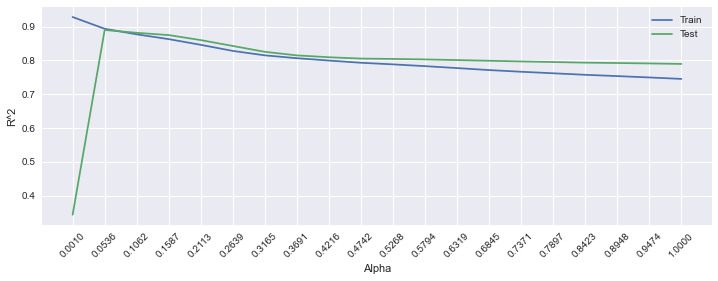

In [92]:
#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

С помощью графика мы можем подобрать оптимальное значение параметра alpha. Нам нужна такая точка на оси абсцисс, при которой на тестовой выборке наблюдается максимальная метрика и при этом разница между метриками на тренировочной и тестовой выборках минимальна.

Видно, что  на тестовой выборке достигает наибольшего значения в точке 0.0536. Причём в этой точке наблюдается примерное равенство метрик на каждом наборе данных. Далее метрика на тестовой выборке начинает падать.

Обратите внимание, что на тренировочной выборке  непрерывно падает с ростом alpha. Оно и понятно, ведь чем больше alpha, тем сильнее регуляризация и тем меньше модель подстраивается под обучающую выборку.

In [93]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.0536)
#Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))


Train R^2: 0.894
Test R^2: 0.890


## Эластичная сетка (Elastic Net) — это комбинация из двух методов регуляризации.

**Примечание.** Регуляризация присутствует и в модели SGDRegressor, причём она используется по умолчанию. В инициализаторе данного класса есть параметр penalty, который позволяет управлять методом регуляризации. Параметр может принимать значения 'l1', 'l2' и 'elasticnet'. По умолчанию используется L2-регуляризация (penalty='l2'). Коэффициент регуляризации (alpha) по умолчанию равен 0.0001 (относительно слабая регуляризация). Управляя двумя этими параметрами, вы можете настраивать тип регуляризации в SGD-методе и её «силу».